# Assignment:-

# Knn on Amazon Fine Food Reviews analysis

## Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

## 1. Objective:

Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2). Use BoW, TF-IDF, Avg-Word2Vec,TF-IDF-Word2Vec to vectorise the reviews.
Make 70% of them as Train dataset and remaining 30% as Test dataset.
Apply 10-fold cross validation on Train dataset to find K for K-NN.Find Test accuracy of Test data and confusion matrix.


##  Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
# loading required libraries 
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
import warnings
warnings.filterwarnings('ignore')


## 1.1 Connecting SQL File

In [2]:
#Loading the data
con = sqlite3.connect('./final.sqlite')

data = pd.read_sql_query("""
SELECT *
FROM Reviews
""", con)

In [3]:
print(data.shape)
data.head()

(364171, 12)


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


## 1.2 Data Preprocessing

In [4]:
data.Score.value_counts()
#i had done data preprocessing i had stored in final.sqlite now loaded this file no need to do again data preprocessing

positive    307061
negative     57110
Name: Score, dtype: int64

## 1.3 Sorting the data

In [5]:
# Sorting the data according to the time-stamp
sorted_data = data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
sorted_data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


## 1.4 Taking first 100k rows

In [6]:
# We will collect different 100000 rows without repetition from time_sorted_data dataframe
my_final = sorted_data[:100000]
print(my_final.shape)
my_final.head()

(100000, 12)


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


## 1.5 Spliting data into train and test based on time (70:30)


In [7]:
from sklearn.model_selection import train_test_split


x=my_final['CleanedText'].values
y=my_final['Score']

#Splitting data into train test and cross validation 
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size =0.3,random_state = 42)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(70000,)
(30000,)
(70000,)
(30000,)


## 2. Techniques For Vectorization

## Why we have to convert text to vector
By converting text to vector we can use whole power of linear algebra.we can find a plane to seperate

## 2.1 BOW

In [8]:
#Bow

from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(max_features=2000,min_df=50) 
final_counts_Bow_tr= count_vect.fit_transform(x_train)# computing Bow
print("the type of count vectorizer ",type(final_counts_Bow_tr))
print("the shape of out text BOW vectorizer ",final_counts_Bow_tr.get_shape())
print("the number of unique words ", final_counts_Bow_tr.get_shape()[1])
final_counts_Bow_test= count_vect.transform(x_test)# computing Bow
print("the type of count vectorizer ",type(final_counts_Bow_test))
print("the shape of out text BOW vectorizer ",final_counts_Bow_test.get_shape())

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (70000, 2000)
the number of unique words  2000
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (30000, 2000)


## 2.1.1 Standardizing Data

In [9]:
# Data-preprocessing: Standardizing the data

from sklearn import preprocessing
standardized_data_train = preprocessing.normalize(final_counts_Bow_tr)
print(standardized_data_train.shape)
standardized_data_test = preprocessing.normalize(final_counts_Bow_test)
print(standardized_data_test.shape)

(70000, 2000)
(30000, 2000)


## 2.2 Applying 10-fold CV by using brute Algorithm

In [10]:

myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='brute',n_jobs=-1)
    scores = cross_val_score(knn, standardized_data_train, y_train,cv=10, scoring='f1_weighted',n_jobs=-1)
    cv_scores.append(scores.mean())
    
# changing to misclassification error
MSE_bow = [1 - x for x in cv_scores]

# determining best k
optimal_k_bow = neighbors[MSE_bow.index(min(MSE_bow))]  
print('\nThe optimal number of neighbors is %d.' % optimal_k_bow)


The optimal number of neighbors is 7.



The accuracy of the knn classifier in train for k = 7 is 89.758571%


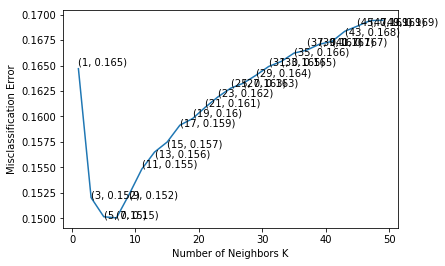

the misclassification error for each k value is :  [0.165 0.152 0.15  0.15  0.152 0.155 0.156 0.157 0.159 0.16  0.161 0.162
 0.163 0.163 0.164 0.165 0.165 0.166 0.167 0.167 0.167 0.168 0.169 0.169
 0.169]


In [11]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k

knn_optimal_bow = KNeighborsClassifier(n_neighbors=optimal_k_bow, algorithm='brute')

# fitting the model
knn_optimal_bow.fit(standardized_data_train,y_train)

# predict the response
pred_bow = knn_optimal_bow.predict(standardized_data_test)
pred1_bow = knn_optimal_bow.predict(standardized_data_train)

# evaluate accuracy
acc_bow = accuracy_score(y_test, pred_bow) * 100
acc1_bow = accuracy_score(y_train, pred1_bow) * 100

 
print('\nThe accuracy of the knn classifier in train for k = %d is %f%%' % (optimal_k_bow, acc1_bow))

# plot misclassification error vs k 
plt.plot(neighbors, MSE_bow)

for xy in zip(neighbors, np.round(MSE_bow,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')                
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE_bow,3))

## 2.3 Error on Test data

In [12]:
# Error on test data
test_error_bow = 100-acc_bow
print("Test Error %f%%" % (test_error_bow))

Test Error 11.226667%


## 2.4 Confusion matrix

In [13]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix
cm_bow = confusion_matrix(y_test,pred_bow)
cm_bow

array([[  458,  3159],
       [  209, 26174]])

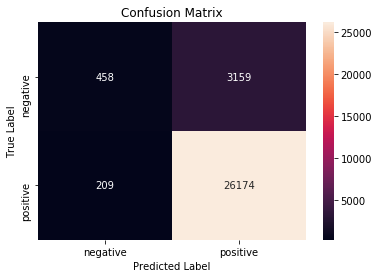

In [14]:
# plot confusion matrix to describe the performance of classifier.

# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_bow, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


## 2.5 Classification Report

In [15]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_bow))

              precision    recall  f1-score   support

    negative       0.69      0.13      0.21      3617
    positive       0.89      0.99      0.94     26383

   micro avg       0.89      0.89      0.89     30000
   macro avg       0.79      0.56      0.58     30000
weighted avg       0.87      0.89      0.85     30000



## 2.6 Precision Score

In [16]:
# Micro-average is preferable if there is a class imbalance problem.
#In Micro-average method, you sum up the individual true positives, false positives, and false negatives of the system for different sets 
from sklearn.metrics import precision_score
precision_score = precision_score(y_test,pred_bow,average='micro')
print("precision_score for the BoW Knn model is = %f" % (precision_score))

precision_score for the BoW Knn model is = 0.887733


## 2.7 Recall Score

In [17]:
from sklearn.metrics import recall_score
recall_score = recall_score(y_test,pred_bow,average='micro')
print("recall_score for the BoW Knn model is = %f" % (recall_score))

recall_score for the BoW Knn model is = 0.887733


In [18]:
#finding out  true negative , false positive , false negative and true positve 
tn, fp, fn, tp = cm_bow.ravel()
( tp, fp, fn, tp)
print(" true negitves are {} \n false positives are {} \n false negatives are {}\n true positives are {} \n ".format(tn,fp,fn,tp))

 true negitves are 458 
 false positives are 3159 
 false negatives are 209
 true positives are 26174 
 


## 3.  10-fold cv using kd-tree

In [19]:
from sklearn.decomposition import TruncatedSVD
final_counts_Bow_tr_svd = TruncatedSVD(n_components=90).fit_transform(final_counts_Bow_tr)
final_counts_Bow_tr_svd1 = TruncatedSVD(n_components=90).fit_transform(final_counts_Bow_test)

## 3.1 Standardizing Data

In [20]:
# Data-preprocessing: Standardizing the data

from sklearn import preprocessing
standardized_data_train = preprocessing.normalize(final_counts_Bow_tr_svd)
print(standardized_data_train.shape)
standardized_data_test = preprocessing.normalize(final_counts_Bow_tr_svd1)
print(standardized_data_test.shape)

(70000, 90)
(30000, 90)


In [21]:
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree', n_jobs=-1)
    scores = cross_val_score(knn, standardized_data_train, y_train, cv=10, scoring='f1_weighted',n_jobs = -1)
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE_bow_kdtree = [1 - x for x in cv_scores]

# determining best k
optimal_k_bow_kdtree = neighbors[MSE_bow_kdtree.index(min(MSE_bow_kdtree))]
print('\nThe optimal number of neighbors is %d.' % optimal_k_bow_kdtree)


The optimal number of neighbors is 9.


In [22]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal_bow_kdtree = KNeighborsClassifier(n_neighbors=optimal_k_bow_kdtree, algorithm = 'kd_tree')

# fitting the model
knn_optimal_bow_kdtree.fit(standardized_data_train, y_train)

# predict the response
pred_bow_kdtree = knn_optimal_bow_kdtree.predict(standardized_data_test)
pred1_bow_kdtree = knn_optimal_bow_kdtree.predict(standardized_data_train)


# evaluate accuracy
acc_bow_kdtree = accuracy_score(y_test, pred_bow_kdtree) * 100
acc1_bow_kdtree = accuracy_score(y_train, pred1_bow_kdtree) * 100

print('\nThe accuracy of the knn classifier in test for k = %d is %f%%' % (optimal_k_bow_kdtree, acc_bow_kdtree))
print('\nThe accuracy of the knn classifier in train for k = %d is %f%%' % (optimal_k_bow_kdtree, acc1_bow_kdtree))


The accuracy of the knn classifier in test for k = 9 is 86.143333%

The accuracy of the knn classifier in train for k = 9 is 89.177143%


## 3.2 Error on Test data

In [23]:
# Error on test data
test_error_bow = 100-acc_bow_kdtree
print("Test Error %f%%" % (test_error_bow))

Test Error 13.856667%


## 3.3 Confusion Matrix

In [24]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_bow_kdtree = confusion_matrix(y_test, pred_bow_kdtree)
cm_bow_kdtree

array([[   92,  3525],
       [  632, 25751]])

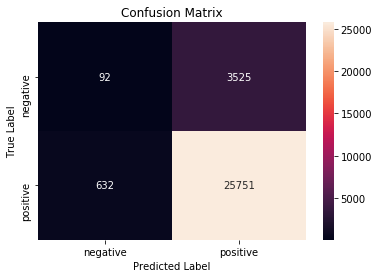

In [25]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_bow_kdtree, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## 3.4 Precision Score

In [26]:
# Micro-average is preferable if there is a class imbalance problem.
#In Micro-average method, you sum up the individual true positives, false positives, and false negatives of the system for different sets 
from sklearn.metrics import precision_score
precision_score = precision_score(y_test,pred_bow_kdtree,average='micro')
print("precision_score for the BoW Knn model is = %f" % (precision_score))

precision_score for the BoW Knn model is = 0.861433


## 3.5 Recall Score

In [27]:
from sklearn.metrics import recall_score
recall_score = recall_score(y_test,pred_bow_kdtree,average='micro')
print("recall_score for the BoW Knn model is = %f" % (recall_score))

recall_score for the BoW Knn model is = 0.861433


In [28]:
#finding out  true negative , false positive , false negative and true positve 
tn, fp, fn, tp = cm_bow_kdtree.ravel()
( tp, fp, fn, tp)
print(" true negitves are {} \n false positives are {} \n false negatives are {}\n true positives are {} \n ".format(tn,fp,fn,tp))

 true negitves are 92 
 false positives are 3525 
 false negatives are 632
 true positives are 25751 
 


## 4. TF-IDF

In [29]:
#tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer(max_features=2000,min_df=50)

In [30]:
final_counts_tfidf_tr= tf_idf_vect.fit_transform(x_train)
print("the type of count vectorizer ",type(final_counts_tfidf_tr))
print("the shape of out text tfidf vectorizer ",final_counts_tfidf_tr.get_shape())
print("the number of unique words ", final_counts_tfidf_tr.get_shape()[1])
final_counts_tfidf_test= tf_idf_vect.transform(x_test)
print("the type of count vectorizer ",type(final_counts_tfidf_test))
print("the shape of out text tfidf vectorizer ",final_counts_tfidf_test.get_shape())
print("the number of unique words ", final_counts_tfidf_test.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text tfidf vectorizer  (70000, 2000)
the number of unique words  2000
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text tfidf vectorizer  (30000, 2000)
the number of unique words  2000


## 4.1 Standardizing Data

In [31]:
# Data-preprocessing: Standardizing the data
from sklearn import preprocessing
standardized_data_train = preprocessing.normalize(final_counts_tfidf_tr)
print(standardized_data_train.shape)
standardized_data_test = preprocessing.normalize(final_counts_tfidf_test)
print(standardized_data_test.shape)

(70000, 2000)
(30000, 2000)


## 4.2 Applying 10-fold CV by using brute algorithm

In [32]:
#Calculating 10 fold CV 

# creating odd list of K for KNN
myList_tfidf = list(range(0,50))
neighbors_tfidf = list(filter(lambda x: x % 2 != 0, myList_tfidf))

# empty list that will hold cv scores
cv_scores_tfidf = []

# perform 10-fold cross validation
for k in neighbors_tfidf:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='brute', n_jobs=-1)
    scores = cross_val_score(knn, standardized_data_train, y_train, cv=10, scoring='f1_weighted',n_jobs=-1)
    cv_scores_tfidf.append(scores.mean())

# changing to misclassification error
MSE_tfidf = [1 - x for x in cv_scores_tfidf]

# determining best k
optimal_k_tfidf = neighbors_tfidf[MSE_tfidf.index(min(MSE_tfidf))]
print('\nThe optimal number of neighbors is %d.' % optimal_k_tfidf)


The optimal number of neighbors is 5.



The accuracy of the knn classifier in test for k = 5 is 88.690000%

The accuracy of the knn classifier in train for k = 5 is 90.204286%


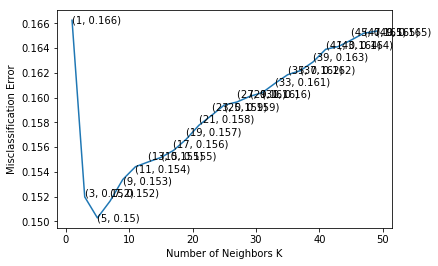

the misclassification error for each k value is :  [0.166 0.152 0.15  0.152 0.153 0.154 0.155 0.155 0.156 0.157 0.158 0.159
 0.159 0.16  0.16  0.16  0.161 0.162 0.162 0.163 0.164 0.164 0.165 0.165
 0.165]


In [33]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal_tfidf = KNeighborsClassifier(n_neighbors=optimal_k_tfidf, algorithm='brute')

# fitting the model
knn_optimal_tfidf.fit(standardized_data_train,y_train)

# predict the response
pred_tfidf = knn_optimal_tfidf.predict(standardized_data_test)
pred1_tfidf = knn_optimal_tfidf.predict(standardized_data_train)

# evaluate accuracy
acc_tfidf = accuracy_score(y_test, pred_tfidf) * 100
acc1_tfidf = accuracy_score(y_train, pred1_tfidf) * 100

print('\nThe accuracy of the knn classifier in test for k = %d is %f%%' % (optimal_k_tfidf, acc_tfidf))
print('\nThe accuracy of the knn classifier in train for k = %d is %f%%' % (optimal_k_tfidf, acc1_tfidf))

# plot misclassification error vs k 
plt.plot(neighbors, MSE_tfidf)

for xy in zip(neighbors, np.round(MSE_tfidf,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE_tfidf,3))

## 4.3 Error on Test data

In [34]:
# Error on test data
test_error_tfidf = 100-acc_tfidf
print("Test Error %f%%" % (test_error_tfidf))

Test Error 11.310000%


## 4.4 Confusion matrix

In [35]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_tfidf = confusion_matrix(y_test, pred_tfidf)
cm_tfidf

array([[  534,  3083],
       [  310, 26073]])

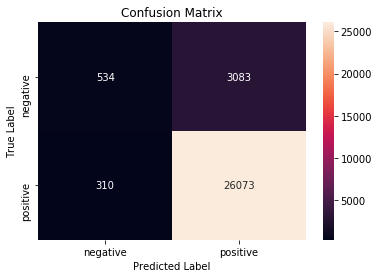

In [36]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm_tfidf = pd.DataFrame(cm_tfidf, index = class_label, columns = class_label)
sns.heatmap(df_cm_tfidf, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## 4.5 Classification Report

In [37]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_tfidf))

              precision    recall  f1-score   support

    negative       0.63      0.15      0.24      3617
    positive       0.89      0.99      0.94     26383

   micro avg       0.89      0.89      0.89     30000
   macro avg       0.76      0.57      0.59     30000
weighted avg       0.86      0.89      0.85     30000



## 4.6 Precision Score

In [38]:
# Micro-average is preferable if there is a class imbalance problem.
#In Micro-average method, you sum up the individual true positives, false positives, and false negatives of the system for different sets 
from sklearn.metrics import precision_score
precision_score = precision_score(y_test,pred_tfidf,average='micro')
print("precision_score for the tfidf Knn model is = %f" % (precision_score))

precision_score for the tfidf Knn model is = 0.886900


## 4.7 Recall Score

In [39]:
from sklearn.metrics import recall_score
recall_score = recall_score(y_test,pred_tfidf,average='micro')
print("recall_score for the tfidf Knn model is = %f" % (recall_score))

recall_score for the tfidf Knn model is = 0.886900


In [40]:
#finding out  true negative , false positive , false negative and true positve 
tn, fp, fn, tp = cm_tfidf.ravel()
( tp, fp, fn, tp)
print(" true negitves are {} \n false positives are {} \n false negatives are {}\n true positives are {} \n ".format(tn,fp,fn,tp))

 true negitves are 534 
 false positives are 3083 
 false negatives are 310
 true positives are 26073 
 


## 5.                             10-fold cv using kd-tree

In [41]:
from sklearn.decomposition import TruncatedSVD
final_counts_tfidf_svd = TruncatedSVD(n_components=90).fit_transform(final_counts_tfidf_tr)
final_counts_tfidf_svd1 = TruncatedSVD(n_components=90).fit_transform(final_counts_tfidf_test)

## 5.1 Standardizing the data

In [42]:
# Data-preprocessing: Standardizing the data

from sklearn import preprocessing
standardized_data_train = preprocessing.normalize(final_counts_tfidf_svd)
print(standardized_data_train.shape)
standardized_data_test = preprocessing.normalize(final_counts_tfidf_svd1)
print(standardized_data_test.shape)

(70000, 90)
(30000, 90)


In [43]:
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree', n_jobs=-1)
    scores = cross_val_score(knn, standardized_data_train, y_train, cv=10, scoring='f1_weighted',n_jobs=-1)
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE_tfifd_kdtree = [1 - x for x in cv_scores]

# determining best k
optimal_k_tfifd_kdtree = neighbors[MSE_tfifd_kdtree.index(min(MSE_tfifd_kdtree))]
print('\nThe optimal number of neighbors is %d.' % optimal_k_tfifd_kdtree)


The optimal number of neighbors is 9.


In [44]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k_tfifd_kdtree, algorithm = 'kd_tree')

# fitting the model
knn_optimal.fit(standardized_data_train, y_train)

# predict the response
pred_tfifd_kdtree = knn_optimal.predict(standardized_data_test)
pred1_tfifd_kdtree = knn_optimal.predict(standardized_data_train)


# evaluate accuracy
acc_tfifd_kdtree = accuracy_score(y_test, pred_tfifd_kdtree) * 100
acc1_tfifd_kdtree = accuracy_score(y_train, pred1_tfifd_kdtree) * 100

print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k_tfifd_kdtree, acc_tfifd_kdtree))
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k_tfifd_kdtree, acc1_tfifd_kdtree))


The accuracy of the knn classifier for k = 9 is 87.136667%

The accuracy of the knn classifier for k = 9 is 89.754286%


## 5.2 Error on Test data

In [45]:
# Error on test data
test_error_tfidf_kdtree = 100-acc_tfifd_kdtree
print("Test Error %f%%" % (test_error_tfidf_kdtree))

Test Error 12.863333%


## 5.3 Confusion Matrix

In [46]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_tfifd_kdtree = confusion_matrix(y_test, pred_tfifd_kdtree)
cm_tfifd_kdtree

array([[   78,  3539],
       [  320, 26063]])

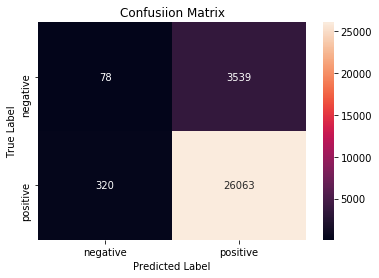

In [47]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm_tfifd_kdtree = pd.DataFrame(cm_tfifd_kdtree, index = class_label, columns = class_label)
sns.heatmap(df_cm_tfifd_kdtree, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## 5.4 Classification Report

In [48]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_tfifd_kdtree))


              precision    recall  f1-score   support

    negative       0.20      0.02      0.04      3617
    positive       0.88      0.99      0.93     26383

   micro avg       0.87      0.87      0.87     30000
   macro avg       0.54      0.50      0.48     30000
weighted avg       0.80      0.87      0.82     30000



## 5.5 Precision Score

In [49]:
# Micro-average is preferable if there is a class imbalance problem.
#In Micro-average method, you sum up the individual true positives, false positives, and false negatives of the system for different sets 
from sklearn.metrics import precision_score
precision_score = precision_score(y_test,pred_tfifd_kdtree,average='micro')
print("precision_score for the tfidf_kdtree Knn model is = %f" % (precision_score))

precision_score for the tfidf_kdtree Knn model is = 0.871367


## 5.6 Recall Score

In [50]:
from sklearn.metrics import recall_score
recall_score = recall_score(y_test,pred_tfifd_kdtree,average='micro')
print("recall_score for the tfidf_kdtree Knn model is = %f" % (recall_score))

recall_score for the tfidf_kdtree Knn model is = 0.871367


In [51]:
#finding out  true negative , false positive , false negative and true positve 
tn, fp, fn, tp = cm_tfifd_kdtree.ravel()
( tp, fp, fn, tp)
print(" true negitves are {} \n false positives are {} \n false negatives are {}\n true positives are {} \n ".format(tn,fp,fn,tp))

 true negitves are 78 
 false positives are 3539 
 false negatives are 320
 true positives are 26063 
 


## 6. WORD2VEC

In [52]:
from gensim.models import Word2Vec
# List of sentence in X_train text
sent_of_train=[]
for sent in x_train:
    sent_of_train.append(sent.split())

# List of sentence in X_est text
sent_of_test=[]
for sent in x_test:
    sent_of_test.append(sent.split())   
    
# Train your own Word2Vec model using your own train text corpus 
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(sent_of_train,min_count=5,size=50, workers=4)

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))

number of words that occured minimum 5 times  10698


## 7. Avg Word2Vec

In [53]:
# compute average word2vec for each review for X_train .
train_vectors = []; 
for sent in sent_of_train:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_vectors.append(sent_vec)
    
# compute average word2vec for each review for X_test .
test_vectors = []; 
for sent in sent_of_test:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_vectors.append(sent_vec)

## 7.1 Standardizing Data

In [54]:
# Data-preprocessing: Standardizing the data
from sklearn import preprocessing
standardized_data_train = preprocessing.normalize(train_vectors)
print(standardized_data_train.shape)
standardized_data_test = preprocessing.normalize(test_vectors)
print(standardized_data_test.shape)

(70000, 50)
(30000, 50)


## 7.2 Applying 10-fold CV by using Brute Algorithm

In [55]:
# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute',n_jobs=-1)
    scores = cross_val_score(knn, standardized_data_train, y_train, cv=10, scoring='f1_weighted', n_jobs=-1)
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE_avg_w2v = [1 - x for x in cv_scores]   


# determining best k
optimal_k_avg_w2v = neighbors[cv_scores.index(max(cv_scores))]
print('\nThe optimal number of neighbors is %d.' % optimal_k_avg_w2v)


The optimal number of neighbors is 5.



The accuracy of the knn classifier in test for k = 5 is 89.486667%

The accuracy of the knn classifier in train for k = 5 is 92.068571%


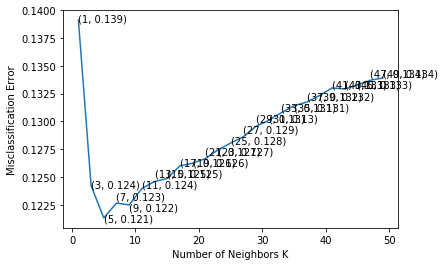

the misclassification error for each k value is :  [0.139 0.124 0.121 0.123 0.122 0.124 0.125 0.125 0.126 0.126 0.127 0.127
 0.128 0.129 0.13  0.13  0.131 0.131 0.132 0.132 0.133 0.133 0.133 0.134
 0.134]


In [56]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal_avg_w2v = KNeighborsClassifier(n_neighbors=optimal_k_avg_w2v, algorithm='brute')

# fitting the model
knn_optimal_avg_w2v.fit(standardized_data_train,y_train)

# predict the response
pred_avg_w2v = knn_optimal_avg_w2v.predict(standardized_data_test)
pred1_avg_w2v = knn_optimal_avg_w2v.predict(standardized_data_train)

# evaluate accuracy
acc_avg_w2v = accuracy_score(y_test, pred_avg_w2v) * 100
acc1_avg_w2v = accuracy_score(y_train, pred1_avg_w2v) * 100

print('\nThe accuracy of the knn classifier in test for k = %d is %f%%' % (optimal_k_avg_w2v, acc_avg_w2v))
print('\nThe accuracy of the knn classifier in train for k = %d is %f%%' % (optimal_k_avg_w2v, acc1_avg_w2v))

# plot misclassification error vs k 
plt.plot(neighbors, MSE_avg_w2v)

for xy in zip(neighbors, np.round(MSE_avg_w2v,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE_avg_w2v,3))

## 7.3 Error on Test data

In [57]:
# Error on test data
test_error_avg_w2v = 100-acc_avg_w2v
print("Test Error %f%%" % (test_error_avg_w2v))

Test Error 10.513333%


## 7.4 Confusion matrix

In [58]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_avg_w2v = confusion_matrix(y_test, pred_avg_w2v)
cm_avg_w2v

array([[ 1122,  2495],
       [  659, 25724]])

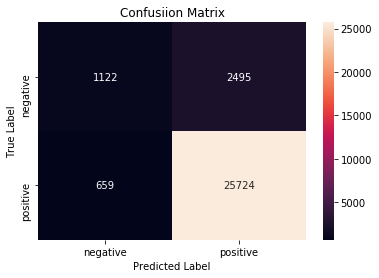

In [59]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm_avg_w2v = pd.DataFrame(cm_avg_w2v, index = class_label, columns = class_label)
sns.heatmap(df_cm_avg_w2v, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## 7.5 Classification Report

In [60]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_avg_w2v))

              precision    recall  f1-score   support

    negative       0.63      0.31      0.42      3617
    positive       0.91      0.98      0.94     26383

   micro avg       0.89      0.89      0.89     30000
   macro avg       0.77      0.64      0.68     30000
weighted avg       0.88      0.89      0.88     30000



## 7.6 Precision Score

In [61]:
# Micro-average is preferable if there is a class imbalance problem.
#In Micro-average method, you sum up the individual true positives, false positives, and false negatives of the system for different sets 
from sklearn.metrics import precision_score
precision_score = precision_score(y_test,pred_avg_w2v,average='micro')
print("precision_score for the avg_w2v Knn model is = %f" % (precision_score))

precision_score for the avg_w2v Knn model is = 0.894867


## 7.7 Recall Score

In [62]:
from sklearn.metrics import recall_score
recall_score = recall_score(y_test,pred_avg_w2v,average='micro')
print("recall_score for the avg_w2v Knn model is = %f" % (recall_score))

recall_score for the avg_w2v Knn model is = 0.894867


In [63]:
#finding out  true negative , false positive , false negative and true positve 
tn, fp, fn, tp = cm_avg_w2v.ravel()
( tp, fp, fn, tp)
print(" true negitves are {} \n false positives are {} \n false negatives are {}\n true positives are {} \n ".format(tn,fp,fn,tp))

 true negitves are 1122 
 false positives are 2495 
 false negatives are 659
 true positives are 25724 
 


## 8.                  10-fold cv using kd-tree

In [64]:
from sklearn.decomposition import TruncatedSVD
final_counts_avg_w2v_svd = TruncatedSVD(n_components=40).fit_transform(train_vectors)
final_counts_avg_w2v_svd1 = TruncatedSVD(n_components=40).fit_transform(test_vectors)


## 8.1 Standardizing the data

In [65]:
# Data-preprocessing: Standardizing the data

from sklearn import preprocessing
standardized_data_train = preprocessing.normalize(final_counts_avg_w2v_svd)
print(standardized_data_train.shape)
standardized_data_test = preprocessing.normalize(final_counts_avg_w2v_svd1)
print(standardized_data_test.shape)

(70000, 40)
(30000, 40)


In [66]:
# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree',n_jobs=-1)
    scores = cross_val_score(knn, standardized_data_train, y_train, cv=10, scoring='f1_weighted', n_jobs=-1)
    cv_scores.append(scores.mean())
    
# determining best k
optimal_k_avg_w2v_kdtree = neighbors[cv_scores.index(max(cv_scores))]
print('\nThe optimal number of neighbors is %d.' % optimal_k_avg_w2v_kdtree)


The optimal number of neighbors is 5.


In [67]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal_avg_w2v_kdtree = KNeighborsClassifier(n_neighbors=optimal_k_avg_w2v_kdtree, algorithm = 'kd_tree')

# fitting the model
knn_optimal_avg_w2v_kdtree.fit(standardized_data_train, y_train)

# predict the response
pred_avg_w2v_kdtree = knn_optimal_avg_w2v_kdtree.predict(standardized_data_test)
pred1_avg_w2v_kdtree = knn_optimal_avg_w2v_kdtree.predict(standardized_data_train)


# evaluate accuracy
acc_avg_w2v_kdtree = accuracy_score(y_test, pred_avg_w2v_kdtree) * 100
acc1_avg_w2v_kdtree = accuracy_score(y_train, pred1_avg_w2v_kdtree) * 100

print('\nThe accuracy of the knn classifier in test for k = %d is %f%%' % (optimal_k_avg_w2v_kdtree, acc_avg_w2v_kdtree))
print('\nThe accuracy of the knn classifier in train for k = %d is %f%%' % (optimal_k_avg_w2v_kdtree, acc1_avg_w2v_kdtree))


The accuracy of the knn classifier in test for k = 5 is 84.723333%

The accuracy of the knn classifier in train for k = 5 is 92.117143%


## 8.2 Error on Test data

In [68]:
# Error on test data
test_error_avg_w2v_kdtree = 100-acc_avg_w2v_kdtree
print("Test Error %f%%" % (test_error_avg_w2v_kdtree))

Test Error 15.276667%


## 8.3 Confusion Matrix

In [69]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_avg_w2v_kdtree = confusion_matrix(y_test, pred_avg_w2v_kdtree)
cm_avg_w2v_kdtree

array([[   41,  3576],
       [ 1007, 25376]])

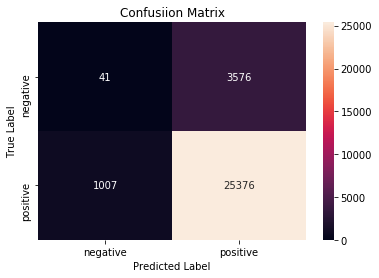

In [70]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm_avg_w2v_kdtree = pd.DataFrame(cm_avg_w2v_kdtree, index = class_label, columns = class_label)
sns.heatmap(df_cm_avg_w2v_kdtree, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## 8.4 Classification Report


In [71]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_avg_w2v_kdtree))

              precision    recall  f1-score   support

    negative       0.04      0.01      0.02      3617
    positive       0.88      0.96      0.92     26383

   micro avg       0.85      0.85      0.85     30000
   macro avg       0.46      0.49      0.47     30000
weighted avg       0.78      0.85      0.81     30000



## 8.5 Precision Score

In [72]:
# Micro-average is preferable if there is a class imbalance problem.
#In Micro-average method, you sum up the individual true positives, false positives, and false negatives of the system for different sets 
from sklearn.metrics import precision_score
precision_score = precision_score(y_test,pred_avg_w2v_kdtree,average='micro')
print("precision_score for the Avg_w2v Knn model is = %f" % (precision_score))

precision_score for the Avg_w2v Knn model is = 0.847233


## 8.6 Recall Score

In [73]:
from sklearn.metrics import recall_score
recall_score = recall_score(y_test,pred_avg_w2v_kdtree,average='micro')
print("recall_score for the Avg_w2v Knn model is = %f" % (recall_score))

recall_score for the Avg_w2v Knn model is = 0.847233


In [74]:
#finding out  true negative , false positive , false negative and true positve 
tn, fp, fn, tp = cm_avg_w2v_kdtree.ravel()
( tp, fp, fn, tp)
print(" true negitves are {} \n false positives are {} \n false negatives are {}\n true positives are {} \n ".format(tn,fp,fn,tp))

 true negitves are 41 
 false positives are 3576 
 false negatives are 1007
 true positives are 25376 
 


## 9. TFIDF-Word2Vec

In [75]:
#tf-idf weighted w2v

from sklearn.feature_extraction.text import TfidfVectorizer

tfidfw2v_vect = TfidfVectorizer()
final_counts_tfidfw2v_train= tfidfw2v_vect.fit_transform(x_train) 
print(type(final_counts_tfidfw2v_train))
print(final_counts_tfidfw2v_train.shape)

final_counts_tfidfw2v_test= tfidfw2v_vect.transform(x_test) 
print(type(final_counts_tfidfw2v_test))
print(final_counts_tfidfw2v_test.shape)

<class 'scipy.sparse.csr.csr_matrix'>
(70000, 31419)
<class 'scipy.sparse.csr.csr_matrix'>
(30000, 31419)


In [76]:
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidfw2v_vect.get_feature_names(), list(tfidfw2v_vect.idf_)))


# TF-IDF weighted Word2Vec
tfidf_feat = tfidfw2v_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in sent_of_train: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

#Test case

tfidf_sent_vectors1 = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in sent_of_test: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors1.append(sent_vec)
    row += 1
print(len(tfidf_sent_vectors))
print(len(tfidf_sent_vectors1))




70000
30000


## 9.1 Standardizing Data

In [77]:
# Data-preprocessing: Standardizing the data
from sklearn import preprocessing
standardized_data_train = preprocessing.normalize(tfidf_sent_vectors)
print(standardized_data_train.shape)
standardized_data_test = preprocessing.normalize(tfidf_sent_vectors1)
print(standardized_data_test.shape)


(70000, 50)
(30000, 50)


## 9.2 Applying 10-fold CV by using Brute Algorithm

In [78]:
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='brute',n_jobs=-1)
    scores = cross_val_score(knn, standardized_data_train, y_train,cv=10, scoring='f1_weighted',n_jobs=-1)
    cv_scores.append(scores.mean())
    
# changing to misclassification error
MSE_tfidf_w2v = [1 - x for x in cv_scores]

# determining best k
optimal_k_tfidf_w2v = neighbors[MSE_tfidf_w2v.index(min(MSE_tfidf_w2v))]  
print('\nThe optimal number of neighbors using brute is',optimal_k_tfidf_w2v)


The optimal number of neighbors using brute is 9



The accuracy of the knn classifier in test for k = 9 is 89.210000%

The accuracy of the knn classifier in train for k = 9 is 90.445714%


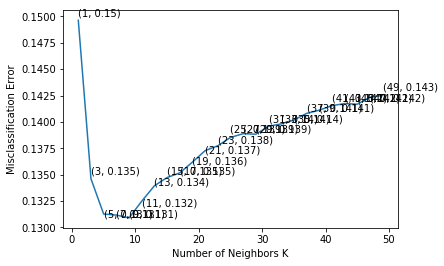

the misclassification error for each k value is :  [0.15  0.135 0.131 0.131 0.131 0.132 0.134 0.135 0.135 0.136 0.137 0.138
 0.139 0.139 0.139 0.14  0.14  0.14  0.141 0.141 0.142 0.142 0.142 0.142
 0.143]


In [79]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k

#def KNN_optimal(standardized_data_train,y_tr,standardized_data_cv,y_cv,optimal_k):
knn_optimal_tfidf_w2v = KNeighborsClassifier(n_neighbors=optimal_k_tfidf_w2v, algorithm='brute')

# fitting the model
knn_optimal_tfidf_w2v.fit(standardized_data_train,y_train)

# predict the response
pred_tfidf_w2v = knn_optimal_tfidf_w2v.predict(standardized_data_test)
pred1_tfidf_w2v = knn_optimal_tfidf_w2v.predict(standardized_data_train)

# evaluate accuracy
acc_tfidf_w2v = accuracy_score(y_test, pred_tfidf_w2v) * 100
acc1_tfidf_w2v = accuracy_score(y_train, pred1_tfidf_w2v) * 100

print('\nThe accuracy of the knn classifier in test for k = %d is %f%%' % (optimal_k_tfidf_w2v, acc_tfidf_w2v))
print('\nThe accuracy of the knn classifier in train for k = %d is %f%%' % (optimal_k_tfidf_w2v, acc1_tfidf_w2v))

# plot misclassification error vs k 
plt.plot(neighbors, MSE_tfidf_w2v)

for xy in zip(neighbors, np.round(MSE_tfidf_w2v,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')                
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE_tfidf_w2v,3))


## 9.3 Error on Test data

In [80]:
# Error on test data
test_error_tfidf_w2v = 100-acc_tfidf_w2v
print("Test Error %f%%" % (test_error_tfidf_w2v))

Test Error 10.790000%


## 9.4 Confusion Matrix

In [81]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_tfidf_w2v = confusion_matrix(y_test, pred_tfidf_w2v)
cm_tfidf_w2v

array([[  859,  2758],
       [  479, 25904]])

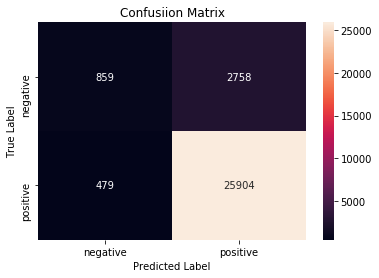

In [82]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm_tfidf_w2v = pd.DataFrame(cm_tfidf_w2v, index = class_label, columns = class_label)
sns.heatmap(df_cm_tfidf_w2v, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## 9.5 Precision Score

In [83]:
# Micro-average is preferable if there is a class imbalance problem.
#In Micro-average method, you sum up the individual true positives, false positives, and false negatives of the system for different sets 
from sklearn.metrics import precision_score
precision_score = precision_score(y_test,pred_tfidf_w2v,average='micro')
print("precision_score for the tfidf_w2v Knn model is = %f" % (precision_score))

precision_score for the tfidf_w2v Knn model is = 0.892100


## 9.6 Recall Score

In [84]:
from sklearn.metrics import recall_score
recall_score = recall_score(y_test,pred_tfidf_w2v,average='micro')
print("recall_score for the tfidf_w2v Knn model is = %f" % (recall_score))

recall_score for the tfidf_w2v Knn model is = 0.892100


In [85]:
#finding out  true negative , false positive , false negative and true positve 
tn, fp, fn, tp = cm_tfidf_w2v.ravel()
( tp, fp, fn, tp)
print(" true negitves are {} \n false positives are {} \n false negatives are {}\n true positives are {} \n ".format(tn,fp,fn,tp))

 true negitves are 859 
 false positives are 2758 
 false negatives are 479
 true positives are 25904 
 


## 10.     10-fold cv using kd-tree


In [86]:
from sklearn.decomposition import TruncatedSVD
final_counts_tfidf_w2v_svd = TruncatedSVD(n_components=40).fit_transform(tfidf_sent_vectors)
final_counts_tfidf_w2v_svd1 = TruncatedSVD(n_components=40).fit_transform(tfidf_sent_vectors1)

## 10.1 Standardizing Data

In [87]:
from sklearn import preprocessing
standardized_data_train = preprocessing.normalize(final_counts_tfidf_w2v_svd)
print(standardized_data_train.shape)
standardized_data_test = preprocessing.normalize(final_counts_tfidf_w2v_svd1)
print(standardized_data_test.shape)

(70000, 40)
(30000, 40)


In [88]:
# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree',n_jobs=-1)
    scores = cross_val_score(knn, train_vectors, y_train, cv=10, scoring='f1_weighted', n_jobs=-1)
    cv_scores.append(scores.mean())
    
# determining best k
optimal_k_tfidf_w2v_kdtree = neighbors[cv_scores.index(max(cv_scores))]
print('\nThe optimal number of neighbors is %d.' % optimal_k_tfidf_w2v_kdtree)


The optimal number of neighbors is 7.


In [89]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal_tfidf_w2v_kdtree = KNeighborsClassifier(n_neighbors=optimal_k_tfidf_w2v_kdtree, algorithm = 'kd_tree')

# fitting the model
knn_optimal_tfidf_w2v_kdtree.fit(standardized_data_train, y_train)

# predict the response
pred_tfidf_w2v_kdtree = knn_optimal_tfidf_w2v_kdtree.predict(standardized_data_test)
pred1_tfidf_w2v_kdtree = knn_optimal_tfidf_w2v_kdtree.predict(standardized_data_train)


# evaluate accuracy
acc_tfidf_w2v_kdtree = accuracy_score(y_test, pred_tfidf_w2v_kdtree) * 100
acc1_tfidf_w2v_kdtree = accuracy_score(y_train, pred1_tfidf_w2v_kdtree) * 100

print('\nThe accuracy of the knn classifier for test k = %d is %f%%' % (optimal_k_tfidf_w2v_kdtree, acc_tfidf_w2v_kdtree))
print('\nThe accuracy of the knn classifier for train k = %d is %f%%' % (optimal_k_tfidf_w2v_kdtree, acc1_tfidf_w2v_kdtree))


The accuracy of the knn classifier for test k = 7 is 87.913333%

The accuracy of the knn classifier for train k = 7 is 90.725714%


## 10.2 Error on Test data

In [90]:
# Error on test data
test_error_tfidf_w2v_kdtree = 100-acc_tfidf_w2v_kdtree
print("Train Error %f%%" % (test_error_tfidf_w2v_kdtree))

Train Error 12.086667%


## 10.3 Confusion Matrix

In [91]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_tfidf_w2v_kdtree = confusion_matrix(y_test, pred_tfidf_w2v_kdtree)
cm_tfidf_w2v_kdtree

array([[  757,  2860],
       [  766, 25617]])

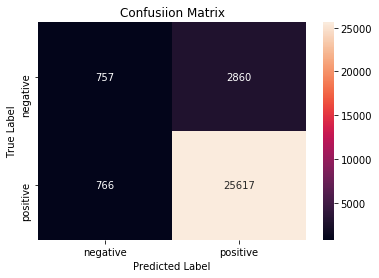

In [92]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm_tfidf_w2v_kdtree = pd.DataFrame(cm_tfidf_w2v_kdtree, index = class_label, columns = class_label)
sns.heatmap(df_cm_tfidf_w2v_kdtree, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## 10.4 Classification Report

In [93]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_tfidf_w2v_kdtree))

              precision    recall  f1-score   support

    negative       0.50      0.21      0.29      3617
    positive       0.90      0.97      0.93     26383

   micro avg       0.88      0.88      0.88     30000
   macro avg       0.70      0.59      0.61     30000
weighted avg       0.85      0.88      0.86     30000



## 10.5 Precision Score

In [94]:
# Micro-average is preferable if there is a class imbalance problem.
#In Micro-average method, you sum up the individual true positives, false positives, and false negatives of the system for different sets 
from sklearn.metrics import precision_score
precision_score = precision_score(y_test,pred_tfidf_w2v_kdtree,average='micro')
print("precision_score for the tfidf_w2v_kdtree Knn model is = %f" % (precision_score))

precision_score for the tfidf_w2v_kdtree Knn model is = 0.879133


## 10.6 Recall Score

In [95]:
from sklearn.metrics import recall_score
recall_score = recall_score(y_test,pred_tfidf_w2v_kdtree,average='micro')
print("recall_score for the tfidf_w2v_kdtree Knn model is = %f" % (recall_score))

recall_score for the tfidf_w2v_kdtree Knn model is = 0.879133


In [96]:
#finding out  true negative , false positive , false negative and true positve 
tn, fp, fn, tp = cm_tfidf_w2v_kdtree.ravel()
( tp, fp, fn, tp)
print(" true negitves are {} \n false positives are {} \n false negatives are {}\n true positives are {} \n ".format(tn,fp,fn,tp))

 true negitves are 757 
 false positives are 2860 
 false negatives are 766
 true positives are 25617 
 


## 11 Pretty Table

In [97]:
# Creating table using PrettyTable library
from prettytable import PrettyTable

names = ["KNN using 'brute' for BoW", "KNN using 'kdTree' for BoW", "KNN using 'brute' for TFIDF", \
        "KNN using 'kdTree' for TFIDF", "KNN using 'brute' for Avg-Word2Vec", "KNN using 'kdTree' for Avg-Word2Vec", \
        "KNN using 'brute' for TFIDF-Word2Vec", "KNN using 'kdTree' for TFIDF-Word2Vec"]

optimal_K = [optimal_k_bow,optimal_k_bow_kdtree,optimal_k_tfidf,optimal_k_tfifd_kdtree,optimal_k_avg_w2v,optimal_k_avg_w2v_kdtree,\
             optimal_k_tfidf_w2v,optimal_k_tfidf_w2v_kdtree]

train_acc = [acc1_bow,acc1_bow_kdtree,acc1_tfidf,acc1_tfifd_kdtree,acc1_avg_w2v,acc1_avg_w2v_kdtree,acc1_tfidf_w2v,acc1_tfidf_w2v_kdtree]

test_acc = [acc_bow,acc_bow_kdtree,acc_tfidf,acc_tfifd_kdtree,acc_avg_w2v,acc_avg_w2v_kdtree,acc_tfidf_w2v,acc_tfidf_w2v_kdtree]

numbering = [1,2,3,4,5,6,7,8]

# Initializing prettytable
ptable = PrettyTable()

# Adding columns
ptable.add_column("S.NO.",numbering)
ptable.add_column("MODEL",names)
ptable.add_column("Best K",optimal_K)
ptable.add_column("Training Accuracy",train_acc)
ptable.add_column("Test Accuracy",test_acc)

# Printing the Table
print(ptable)

+-------+---------------------------------------+--------+-------------------+-------------------+
| S.NO. |                 MODEL                 | Best K | Training Accuracy |   Test Accuracy   |
+-------+---------------------------------------+--------+-------------------+-------------------+
|   1   |       KNN using 'brute' for BoW       |   7    | 89.75857142857143 | 88.77333333333334 |
|   2   |       KNN using 'kdTree' for BoW      |   9    | 89.17714285714285 | 86.14333333333335 |
|   3   |      KNN using 'brute' for TFIDF      |   5    | 90.20428571428572 |       88.69       |
|   4   |      KNN using 'kdTree' for TFIDF     |   9    | 89.75428571428571 | 87.13666666666666 |
|   5   |   KNN using 'brute' for Avg-Word2Vec  |   5    | 92.06857142857143 | 89.48666666666666 |
|   6   |  KNN using 'kdTree' for Avg-Word2Vec  |   5    | 92.11714285714285 | 84.72333333333333 |
|   7   |  KNN using 'brute' for TFIDF-Word2Vec |   9    | 90.44571428571429 |       89.21       |
|   8   | 

# 12 Conclusion

K-Nearest Neighbors (KNN) is one of the simplest algorithm used in Machine Learning for regression and classification problem. KNN algorithms use a data and classify new data points based on a similarity measures (e.g. distance function). Classification is done by a majority vote to its neighbors.

Choosing a proper K value is important to the performance of K-Nearest Neighbour. If k value is too large, the nearest neighbor may misclassify the test instance because its list of nearest neighbors may include data points that are located far away from its neighborhood. On the other hand, if k value is too small, then the nearest neighbor classifier may be susceptible to overfitting because of noise in the training data set.

As in "KNN using 'brute' for Avg-Word2Vec" when k = 5 the accuracy is quite good compared to other models. The reason behind selecting KNN using 'brute' for Avg-Word2Vec is it has high accuracy on test data. when we build a model KNN using 'brute' for Avg-Word2Vec it guarantee accuracy by cross validation here test accuraccy plays major role.

In k-nn we should not take k-value even because Classification is done by a majority vote to its neighbors. 

In this model, train_error and test_error is low.As we know when a model performs good on training data but poor performance on unseen data(test data)i.e. its dependent on training data only, tends towards overfits and when a model perform poor performence on training data and good performence on test data i.e. it fails to learn relationship in training data tends towards underfit.

We need to balance between both i.e. reduce training error and reduce error between training and testing error.
Another concept bias vs variance is also related with underfitting and overfitting. when a model has high bias and low variance tend towards underfitting and high variance and low bias called overfitting and we balanced using cross-validataion. 

By crossvalidation Technique we can find right value of k neither overfit nor under fit. By crossvalidation Technique we can guarrantee accuracy.

By accuracy we can sure we are not under fitting nor overfitting


Failure cases of K-NN:-

In K-NN always take k=odd value
if my query point is far away from neighbour points i cannot decide it's particular class
if my positive points and Negative points are jumbled so tightly there is no useful information in these cases my Machine learning algorithms fails

KNN Limitations:-

Knn takes large space complexity of order(nd) and time complexity of order(nd) 


Steps Involved:-

1) Connecting SQL file

2) Data Preprocessing(Already i had done preprocessing no need to do again)

3) Sorting the data based on time

4) Taking 1st 60K Rows (Due to low Ram)

5) Spliting data into train and test based on time (70:30)

6) Techniques For Vectorization Bow,TF-IDF,word2vec,Avgword2vec,tfidfword2vec.

7) Standardizing Data and applying Knn brute force Algorithm and kdtree algorithm

8) I calculated Accuracy,Error on Test Data, Confusion Matrix,Classification Report,Precision Score,Recall Score,F1-Score.

9) I Designed Pretty Table

10) Conclusion

